# Implémentation de l'architecture des réseaux de neurones - log

Changement par rapport au premier notebook : transformation de la PD en F(PD) où F fonction de répartition de la loi exponentielle.

## Chargement des modules et données

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow import keras

from sklearn import preprocessing, model_selection

In [2]:
df = pd.read_csv('market_data_pd.csv',sep=',')

In [3]:
df.head()

df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]
#df = df[df['Common Eqty / Tot Assets']<.4]

In [4]:
#mettre les ratios financiers
df1 = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"TCE Ratio","PD_1y"]]

#df1 = df.drop(columns=['Unnamed: 0','Reference Security', 'Ticker_y','Ticker_x', 'Issuer Name','Maturity','Cpn', 'Bid Price', 'Ask Price'])

#df2 = pd.read_csv('PD_1y.csv')

df1['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
df1.replace(np.nan, 0.0,inplace=True)

<ipython-input-4-a7e076bb519c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
C:\Users\mathilde.binet\Anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [5]:
df1 = df1[df1.PD_1y>0.0]
df1 = df1[df1.PD_1y!=1.0]

In [6]:
#df1 = df1.dropna(how = 'any') 
df1.head()
#on peut pas faire tourner l'algo avec des valeurs manquantes. Voir techniques pour les remplacer.

,Common Eqty / Tot Assets,Debt / Common Equity,BCLASS Level 3,TCE Ratio,PD_1y
0,4.84431,684.499,Banking,4.45822,0.006788
1,17.15800,351.535,Consumer Cyclical,-171.02700,0.065377
2,17.15800,351.535,Consumer Cyclical,-171.02700,0.116526
3,19.24570,410.513,Basic Industry,0.00000,0.014829
4,19.24570,410.513,Basic Industry,0.00000,0.009303


In [7]:
df1.shape

(521, 5)

# I. Préparation des données

# a. Traitement des données

Nous commencerons par séparer les données non étiquietées des étiquettes, les étiquettes se trouvent dans l'array `y_full` et le reste des données dans `X_full`

In [8]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])

La prochaine étape consiste à séparer les features continues des features discrètes, cela sera utile car leurs traitements seront différent

In [9]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level {}'.format(i) for i in range(3,4)]
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

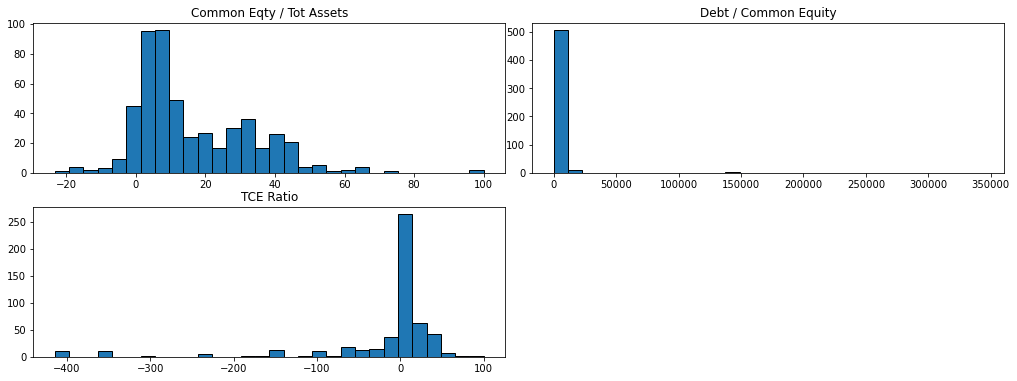

In [10]:
fig = plt.figure(figsize=(14,10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):
    # create a subplot in the (plot_idx+1) position of a 2x2 grid
    ax = fig.add_subplot(4, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X_full[:, feat_idx], bins=30, edgecolor='black')
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
# espacement entre les subplots
fig.tight_layout(pad=0.1)

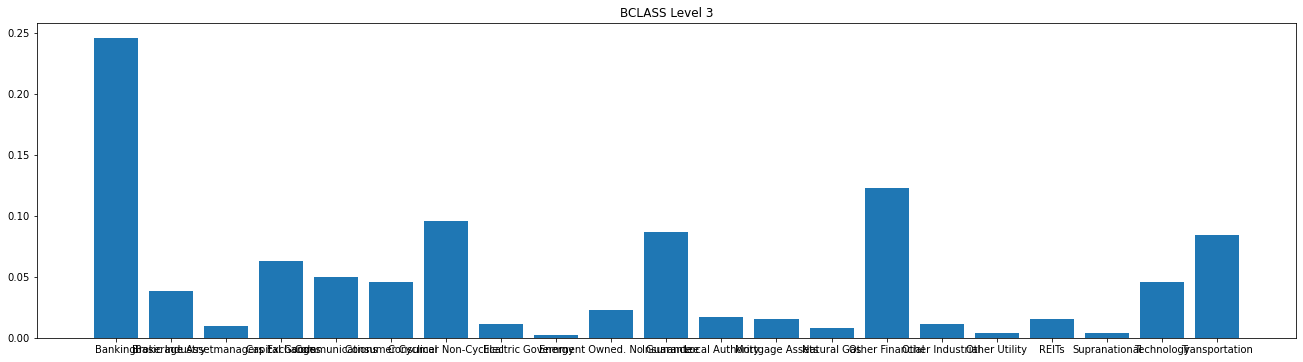

In [11]:
# Bar plots for discrete features
fig = plt.figure(figsize=(18, 14))

for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot in the (plot_idx+1) position of a 1x3 grid
    ax = fig.add_subplot(3, 1, (plot_idx+1))

    feature_values = np.unique(X_full[:, feat_idx])
    frequencies = [(float(len(np.where(X_full[:, feat_idx]==value)[0]))/X_full.shape[0]) \
                   for value in feature_values]
    
    b = ax.bar(range(len(feature_values)), frequencies, width=0.8, 
               tick_label=list([n for n in feature_values]))
    
    
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
fig.tight_layout(pad=0.35)

Séparation en base de test / train. Besoin de distinguer les cas selon le type de variables : 

$-$ variables quali : les binariser avant de séparer en test et train afin d'avoir des colonnes pour toutes les modalités existantes dans le dataset. 

$-$ variable quanti : il faut les standariser en fonction de la base de train, càd : on entraîne la standardisation QUE sur la base de train, puis on applique les coefficients à la base de test également. Important, **sinon notre base de train dépend de la base de test.**

*Transformation des qualis*

In [12]:
def traitement_quali(X):
    
    ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False)
    
    #std_scaler = preprocessing.StandardScaler().fit(X[:,continuous_features_idx])
    #X_continuous_scaled = std_scaler.transform(X[:,continuous_features_idx])
    
    X_processed = np.hstack((ohe.fit_transform(X[:,discrete_features_idx]), X[:,continuous_features_idx]))
    
    return X_processed


In [13]:
nbvar_avant = len(X_full[0])

X_full = traitement_quali(X_full)

nbvar_après = len(X_full[0])
nb_quali = nbvar_après - nbvar_avant + len(discrete_features_idx)

In [14]:
nb_quali

21

*Séparation test et train*

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.20,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

*Transformation des quantis*

In [16]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

scaler.fit(X_train[:,continuous_features_idx])
StandardScaler(copy = True, with_mean = True, with_std = True)

X_train_quanti = scaler.transform(X_train[:,continuous_features_idx])

In [17]:
x_3quali = pd.DataFrame(X_train_quanti)
x_3quanti = pd.DataFrame(X_train[:,:nb_quali])
x_3quali = x_3quali.reset_index()
x_3quanti = x_3quanti.reset_index()
x_3quali = x_3quali.apply(pd.to_numeric)
x_3quanti = x_3quanti.apply(pd.to_numeric)
X_train = pd.merge(x_3quanti, x_3quali, how='inner', on="index")
X_train = X_train.drop(columns = ['index']) 

X_train = np.array(X_train)

In [18]:
X_test_quanti = scaler.transform(X_test[:,continuous_features_idx])

x_4quali = pd.DataFrame(X_test_quanti)
x_4quanti = pd.DataFrame(X_test[:,:nb_quali])
x_4quali = x_4quali.apply(pd.to_numeric)
x_4quanti = x_4quanti.apply(pd.to_numeric)
x_4quali = x_4quali.reset_index()
x_4quanti = x_4quanti.reset_index()
X_test = pd.merge(x_4quanti, x_4quali, how='inner', on="index")
X_test = X_test.drop(columns = ['index']) 

X_test = np.array(X_test)

# b. Transformation de l'output

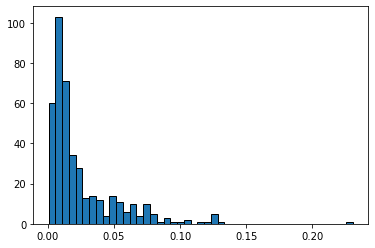

In [19]:
# histogram of the raw data
plt.hist(y_train, bins=45,edgecolor='black')
plt.show()

In [20]:
#attention à bien définir lambda uniquement sur les données d'entraînement (et pas de test)

lam = (1/y_train.mean() + 1/y_train.var()**(1/2)) / 2

In [21]:
def distrib_function(x,lam) : 
    return 1 - np.exp(- lam * x)

y_train_exp = distrib_function(y_train,lam)

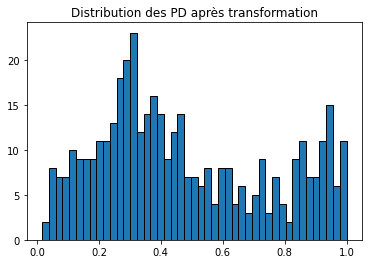

In [22]:
plt.title('Distribution des PD après transformation')
plt.hist(y_train_exp, bins=45,edgecolor='black')
plt.show()

In [23]:
#l'algo va prédire les y_exp (après transformation). 
y_test_exp = distrib_function(y_test,lam)

In [24]:
def inv_distrib(y,lam) : 
    return - np.log(1 - y) / lam 

#La transformation est pas linéaire. Pour regarder les performances de l'algo, il faut revenir à la PD
#(ne pas comparer la PD transformée car erreur dépend de la PD)

# II. Réseaux de neurones - prédiction

In [25]:
model = Sequential()
model.add(Dense(units=6,input_dim=24,activation="sigmoid")) #6 is good
model.add(Dense(units=2))
model.add(Dense(units=1,activation="sigmoid"))
#modele.add(Dropout(0.3))
learning_rate = 0.10

sgd = SGD(learning_rate)

#dim première couche = nombre de variables du df 

In [26]:
#modele.compile(loss='mean_squared_error',optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])
#optimizer = sgd
model.compile(loss='mean_squared_error',optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError()])

Epoch 1/50
40/40 [==============================] - 1s 8ms/step - loss: 0.1696 - mean_squared_error: 0.1696 - val_loss: 0.1570 - val_mean_squared_error: 0.1570
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.1314 - mean_squared_error: 0.1314 - val_loss: 0.1200 - val_mean_squared_error: 0.1200
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - val_loss: 0.0950 - val_mean_squared_error: 0.0950
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0823 - val_mean_squared_error: 0.0823
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0742 - mean_squared_error: 0.0742 - val_loss: 0.0774 - val_mean_squared_error: 0.0774
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0734 - mean_squared_error: 0.0734 - val_loss: 0.0753 - val_mean_squared_error: 0.0753
Epoch 7/50
40/40 [======================

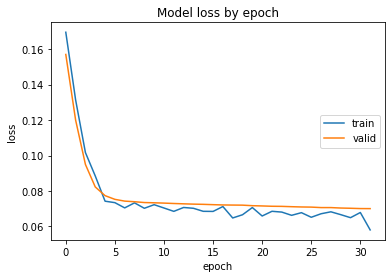

In [27]:
history = model.fit(X_train, y_train_exp,         # Train the model using the training set...
          batch_size=10, epochs=50,
          verbose=1, validation_split=0.4,steps_per_epoch=40)           # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test_exp, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

    
import matplotlib.pyplot as plt

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [28]:
#Résultats 
resultat_exp = model.evaluate(X_test, y_test_exp, verbose=1)
print("Valeur de l'erreur sur les données de test (loss):", resultat_exp[0])
print('Précision sur les données de test (MSE):', resultat_exp[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.0778 - mean_squared_error: 0.0778
Valeur de l'erreur sur les données de test (loss): 0.077753446996212
Précision sur les données de test (MSE): 0.077753446996212


## Observation des résultats 

In [29]:
def ecart_relatif(row) : 
    théo = row['Théorique']
    préd = row['Prédiction']
    return abs(théo - préd) / théo

### en transformation

In [30]:
prediction = pd.DataFrame(data= model.predict(X_test) ,columns=['Prédiction'])
théorique = pd.DataFrame(data= y_test_exp ,columns=['Théorique'])

prediction, théorique = prediction.reset_index() , théorique.reset_index()

results_exp = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
results_exp["Ecart_relatif"] = results_exp.apply(ecart_relatif,axis=1)

<AxesSubplot:xlabel='Théorique', ylabel='Prédiction'>

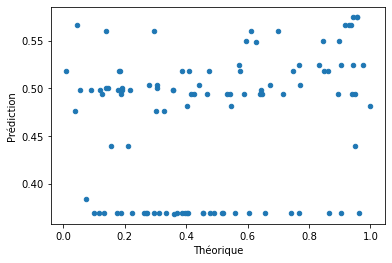

In [31]:
results_exp.plot.scatter("Théorique","Prédiction")


### re-transformation en celui de base

In [32]:
#prediction : faire la transformation inverse car réseau de neurones donne le transformé
prediction = pd.DataFrame(data= inv_distrib(model.predict(X_test),lam) ,columns=['Prédiction'])

#théorique : dataset non transformé 
théorique = pd.DataFrame(data= y_test ,columns=['Théorique'])

prediction, théorique = prediction.reset_index() , théorique.reset_index()

results = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)

In [33]:
results

,Théorique,Prédiction,Ecart_relatif
0,0.013732,0.012176,0.113309
1,0.003355,0.018188,4.420560
2,0.016694,0.017994,0.077874
3,0.003741,0.012176,2.254549
4,0.009243,0.021662,1.343637
...,...,...,...
100,0.005193,0.018188,2.502749
101,0.008364,0.012176,0.455784
102,0.021577,0.012176,0.435698
103,0.086451,0.012176,0.859154


In [34]:
results.replace(np.inf, 0.0,inplace=True)

In [35]:
results["Ecart_relatif"].mean()

2.178104503457383

In [36]:
print("L'écart relatif moyen est de " + str(results["Ecart_relatif"].mean() * 100) + "%")

L'écart relatif moyen est de 217.8104503457383%


In [37]:
results.sort_values('Ecart_relatif',inplace=True)

In [34]:
#results

<AxesSubplot:xlabel='Théorique', ylabel='Prédiction'>

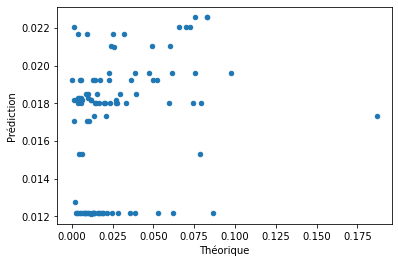

In [38]:
results.plot.scatter("Théorique","Prédiction")

---------------

# Test classification multi-classe

## i. Classification

*Une partie du code voulait pas marcher chez moi. Du coup, j'ai juste repris le traitement des données et séparation train/test fait pour le premier réseau*

In [57]:
#df = pd.read_csv('market_data_pd.csv',sep=',')
#df = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"PD_1y","TCE Ratio"]]
#df = df[df.PD_1y>0.0]
#df = df[df.PD_1y!=1.0]
#df = df[df.PD_1y<0.05]

#df['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
#df.replace(np.nan, 0.0,inplace=True)

In [67]:
#X_full = np.array(df.drop(columns=['PD_1y']))
#y_full = np.array(df['PD_1y'])

#features = list(df.drop(columns=['PD_1y']).columns)

#discrete_features = ['BCLASS Level {}'.format(i) for i in range(3,4)]
#continuous_features = [s for s in features if not s in discrete_features]


#continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
#discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]


#X_processed = traitement(X_full)
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X_processed, y_full, test_size=0.30,
 #                                                                   stratify=y_full, # stratification
  #                                                                  random_state=92)

In [68]:
#y_train_exp = distrib_function(y_train,lam)
#y_test_exp = distrib_function(y_test,lam)

In [91]:
#ARRAY A UTILISER : 
#X_train, y_train, y_train_exp 
#X_test, x_test, x_test_exp

### classification

In [63]:
#à spécifier : le nombre de classes 

nb_class = 6

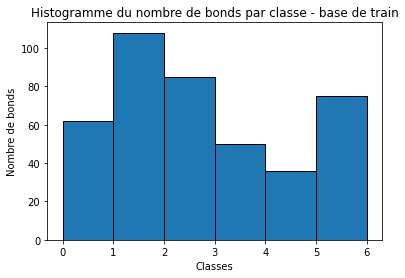

In [66]:
#entraînement de l'algo de classification sur la base de train
from numpy.random import randn
from sklearn.preprocessing import KBinsDiscretizer

y_train2 = y_train_exp.reshape((len(y_train_exp),1))

kbins = KBinsDiscretizer(n_bins= nb_class , encode='ordinal', strategy='kmeans')
y_train_class = kbins.fit_transform(y_train2)

plt.hist(y_train_class, range = (0, nb_class),bins=nb_class,edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de train')
plt.show()

In [40]:
#application de l'algo à la base de train
y_test2 = y_test_exp.reshape((len(y_test_exp),1))
y_test_class = kbins.transform(y_test2)

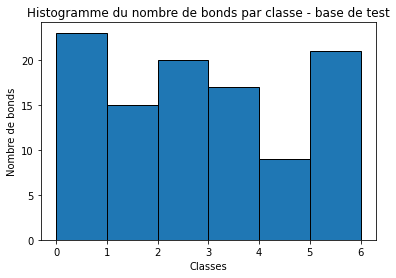

In [67]:
plt.hist(y_test_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de test')
plt.show()

## ii. Réseaux de neurones

In [42]:
model = Sequential()
model.add(Dense(units=6,input_dim=24)) #6 is good
#model.add(Dense(units=2))
model.add(Dense(units=6,activation="sigmoid")) #output


In [43]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [44]:
#model.fit(X_train,y_train,validation_split=0.4, epochs=40)

In [45]:
history = model.fit(X_train, y_train_class,         # Train the model using the training set...
          batch_size=10, epochs=20,
          verbose=1, validation_split=0.4,steps_per_epoch=20)  

Epoch 1/20
20/20 [==============================] - 1s 23ms/step - loss: 1.8406 - sparse_categorical_accuracy: 0.1800 - val_loss: 1.8334 - val_sparse_categorical_accuracy: 0.2036
Epoch 2/20
20/20 [==============================] - 0s 5ms/step - loss: 1.8391 - sparse_categorical_accuracy: 0.2211 - val_loss: 1.8214 - val_sparse_categorical_accuracy: 0.2036
Epoch 3/20
20/20 [==============================] - 0s 4ms/step - loss: 1.8256 - sparse_categorical_accuracy: 0.2111 - val_loss: 1.8093 - val_sparse_categorical_accuracy: 0.2036
Epoch 4/20
20/20 [==============================] - 0s 5ms/step - loss: 1.7962 - sparse_categorical_accuracy: 0.2211 - val_loss: 1.8021 - val_sparse_categorical_accuracy: 0.2036
Epoch 5/20
20/20 [==============================] - 0s 4ms/step - loss: 1.7948 - sparse_categorical_accuracy: 0.1960 - val_loss: 1.7959 - val_sparse_categorical_accuracy: 0.2156
Epoch 6/20
20/20 [==============================] - 0s 5ms/step - loss: 1.7850 - sparse_categorical_accuracy:

4/4 [==============================] - 0s 2ms/step - loss: 1.8206 - sparse_categorical_accuracy: 0.2190
The final loss on the TEST set is: 1.82.
The final sparse_categorical_accuracy on the TEST set is: 0.22.


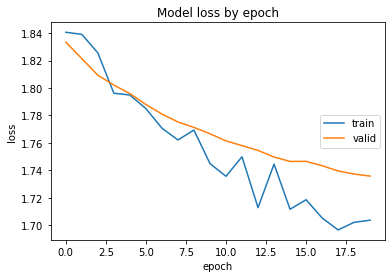

In [46]:
# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test_class, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [47]:
y=model.predict(X_test)

In [48]:
y_predicted = [np.argmax(pred) for pred in y]

In [49]:
for i in range(len(y_predicted)):
    print("predicted: ", y_predicted[i], "| Actual Label: ",int(y_test_class[i][0]), " True" if (y_predicted[i]==y_test_class[i][0]) else " False")
print("\n")
print(np.sum(y_predicted==y_test_class[:,0]),'/',len(y_predicted))

predicted:  1 | Actual Label:  2  False
predicted:  5 | Actual Label:  0  False
predicted:  2 | Actual Label:  2  True
predicted:  1 | Actual Label:  0  False
predicted:  5 | Actual Label:  1  False
predicted:  2 | Actual Label:  5  False
predicted:  2 | Actual Label:  5  False
predicted:  1 | Actual Label:  1  True
predicted:  1 | Actual Label:  0  False
predicted:  1 | Actual Label:  2  False
predicted:  5 | Actual Label:  4  False
predicted:  1 | Actual Label:  0  False
predicted:  1 | Actual Label:  1  True
predicted:  5 | Actual Label:  0  False
predicted:  2 | Actual Label:  3  False
predicted:  5 | Actual Label:  0  False
predicted:  2 | Actual Label:  3  False
predicted:  5 | Actual Label:  2  False
predicted:  2 | Actual Label:  2  True
predicted:  2 | Actual Label:  3  False
predicted:  2 | Actual Label:  2  True
predicted:  1 | Actual Label:  3  False
predicted:  2 | Actual Label:  5  False
predicted:  1 | Actual Label:  0  False
predicted:  5 | Actual Label:  5  True
predic

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
CM = confusion_matrix(y_test_class, y_predicted)

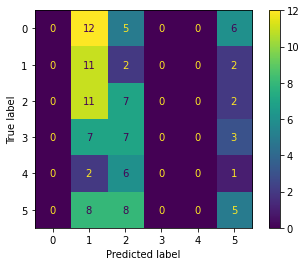

In [52]:
ConfusionMatrixDisplay(CM).plot()